In [1]:
import sys
sys.path.append('../python')
from plot_info import *
from keras.models import Sequential
from keras.layers import Dense, Activation
import keras

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import netCDF4
import os.path

input_size=40
train_size=128
validation_size=200
data_path='/mnt/data/kjetil/deleteme/kh_1.nc'

Using TensorFlow backend.


In [2]:

class AreaFunctional(object):
    def __init__(self, integrate_coordinate = [0.55,0.35], integrate_width=[0.25,0.25],variable='rho'):
        self.integrate_coordinate = integrate_coordinate
        self.integrate_width = integrate_width
        
        self.variable = variable
        self.first = 10
    def area(self, I):
        
        return 4*(I[1][0]-I[0][0])*(I[1][1]-I[0][1])
    def __call__(self, rho):
        N = rho.shape[0]
        
        integrate_area = [[int(N*self.integrate_coordinate[0]), int(N*self.integrate_coordinate[1])],
                          [int(N*self.integrate_coordinate[0]+N*self.integrate_width[0]), 
                           int(N*self.integrate_coordinate[1]+N*self.integrate_width[1])]]
        
        g = sum(rho[integrate_area[0][0]:integrate_area[1][0], integrate_area[0][1]:integrate_area[1][1]])/self.area(integrate_area)
        

        return g
    
    def plot(self, d):
        N = d.shape[0]
        x, y= mgrid[0:1:N*1j,0:1:N*1j]
        plt.pcolormesh(x,y,d)
        rect = matplotlib.patches.Rectangle((self.integrate_coordinate[0],self.integrate_coordinate[1]),
                                     self.integrate_width[0],
                                     self.integrate_width[1],
                                     linewidth=1,edgecolor='r',facecolor='none')
        
        axes = plt.gca()
        axes.add_patch(rect)
        plt.show()
    
    

In [3]:
def get_samples(data_path, functional):
    samples = []
    
    with netCDF4.Dataset(data_path) as f:
        for k in f.variables.keys():
            if functional.variable in k:
                sys.stdout.write("%d\r" % len(samples))
                sys.stdout.flush()
                samples.append(functional(f.variables[k][:,:,0]))
    
    print()
    return array(samples,dtype=float64)
def draw_functional(data_path, functional):
    with netCDF4.Dataset(data_path) as f:
        d = f.variables['sample_10_%s' % functional.variable][:,:,0]
        functional.plot(d)
        

                

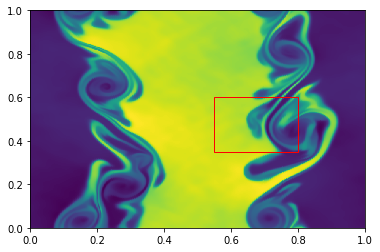

In [4]:
draw_functional(data_path, AreaFunctional())

In [5]:
def get_network_from_functional(data_path, functional, parameters):
    samples = get_samples(data_path, functional)
    return get_network(parameters, samples, train_size=train_size, validation_size=validation_size)
def get_network_from_functional_qmc(data_path, functional):
    parameter_path = os.path.join(os.path.dirname(data_path), 'qmc_points.txt')
    parameters = loadtxt(parameter_path)
    
    return get_network_from_functional(data_path, functional, parameters)
def get_network(parameters, data, *, train_size, validation_size, epochs=5000):
    
        
    input_size = parameters.shape[1]
    model = Sequential([
        Dense(20, input_shape=(input_size,)),
        Activation('relu'),
        Dense(22),
        Activation('relu'),
        Dense(20),
        Activation('relu'),
        Dense(22),
        Activation('relu'),
        Dense(20),
        Activation('relu'),
        Dense(20),
        Activation('relu'),
        Dense(1)
    ])
    model.compile(optimizer=keras.optimizers.SGD(lr=0.01),
                  loss='mean_squared_error')
    x_train = parameters[:train_size,:]
  
    y_train=data[:train_size]
    
    
    x_val = parameters[train_size:validation_size+train_size,:]
    y_val=data[train_size:train_size+validation_size]
   
    epochs_r=range(1, epochs)
   
    hist = model.fit(x_train, y_train,batch_size=train_size, epochs=epochs,shuffle=True,
          validation_data=(x_val, y_val),verbose=0)
    plt.loglog(hist.history['loss'])
    plt.show()
    plt.loglog(hist.history['loss'][4:])
    plt.show()
    plt.loglog(hist.history['loss'][400:])
    plt.show()
    plt.loglog(hist.history['val_loss'])
    plt.show()
    plt.loglog(hist.history['val_loss'][4:])
    plt.show()
    plt.loglog(hist.history['val_loss'][400:])
    plt.show()
    x_test = parameters
    y_test = data
    y_predict = model.predict(x_test)
    print(y_test.shape)
    print(y_predict.shape)
    plt.scatter(y_test, y_predict[:,0])
    plt.xlabel("Actual data")
    plt.ylabel("Predicted data")
    plt.show()
    print(model.summary())
    print("Number of parameters: %d"% model.count_params())
    
    return  model, data, parameters

In [6]:
def get_network_interpolate_qmc(data_path, functional):
    draw_functional(data_path, functional)
    network, data, parameters = get_network_from_functional_qmc(data_path, functional)
    
    from sklearn import linear_model
    reg = linear_model.LinearRegression()
    y_train = data[:train_size]
    coeffs = reg.fit(parameters[:train_size,:], y_train)

    evaluated_lsq = coeffs.predict(parameters)
    plt.scatter(data, evaluated_lsq)
    plt.title('Least squares of degree 1')
    plt.xlabel("Actual data")
    plt.ylabel("Interpolated data")
    plt.show()
    
    def myvar(x):
        mean = sum(x)/x.shape[0]
        var = sum((mean-x)**2)/x.shape[0]
        return var
    
    def mymean (x): 
        return sum(x)/x.shape[0]
    
    
   
    
    variance_top = myvar(data)
    print("variance single level = %f" % variance_top)
    predicted = network.predict(parameters)
    predicted = predicted.reshape(parameters.shape[0])
    variance_diff_ml = myvar(data- predicted)
    
    
    print("variance diff ml = %f " % variance_diff_ml)
    print("speedup = %f" % (variance_top/variance_diff_ml/2.))
    print((data - evaluated_lsq).shape)
    variance_diff_interpolate =myvar(data - evaluated_lsq)
    print("variance_diff_interpolate = %f" % variance_diff_interpolate)
    
    mean_qmc = mymean(data)
    print("mean_qmc = %f" % mean_qmc)
    mean_ml = mymean(network.predict(parameters))
    print("mean_ml = %f" % mean_ml)
    mean_few_qmc = mymean(parameters[:train_size,:])
    
    print("mean_few_qmc = %f" % mean_few_qmc)
    print("mean_lsq = %f" % mean(evaluated_lsq))
    
    
    
    
    predicted_all = network.predict(parameters)
    predicted_all = predicted_all.reshape(parameters.shape[0])
    print(predicted_all.shape)
    mean_mlmlmc = mymean(predicted[:train_size]-data[:train_size]) + mymean(predicted_all)
    
    print("mean_mlmlmc = %f" % mean_mlmlmc)
    var_qmc = myvar(data)
    print("var_qmc = %f" % var_qmc)
    var_ml = myvar(network.predict(parameters))
    print("var_ml = %f" % var_ml)
    var_few_qmc = myvar(parameters[:train_size,:])
    
    print("var_few_qmc = %f" % var_few_qmc)
    print(parameters.shape)
    print("var_lsq = %f" % var(evaluated_lsq))
    
    
    plt.hist(data,bins=40,density=True,label='QMC 8192 samples',alpha=0.5)
    plt.title("Comparison QMC and Machine learning")
    plt.hist(network.predict(parameters),bins=40,density=True,label='ML(%d samples)' % train_size,alpha=0.5)
    plt.legend()
    showAndSave('hist_qmc_ml')
    
    
    plt.title("Comparison QMC with %d and QMC with %d samples" %(8192, train_size))
    plt.hist(data,bins=40,density=True,label='QMC 8192 samples',alpha=0.5)
    plt.hist(data[:train_size],bins=40,density=True, alpha=0.5,label='QMC %d samples' % train_size)
    plt.legend()
    showAndSave('hist_qmc_qmc')
    
    plt.title("Comparison QMC with least squares")
    plt.hist(data,bins=40,density=True,label='QMC 8192 samples',alpha=0.5)
    plt.hist(evaluated_lsq,bins=40,density=True,alpha=0.5, label='Least squares')
    plt.legend()
    showAndSave('hist_qmc_lsq')
    
    return network, data, parameters

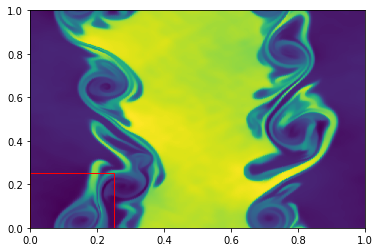

8191


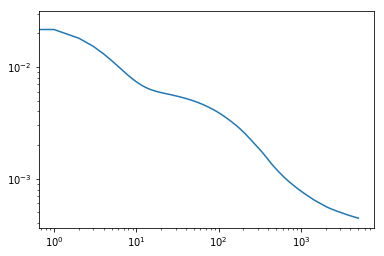

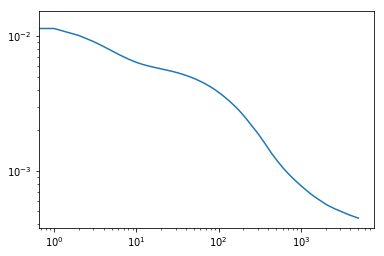

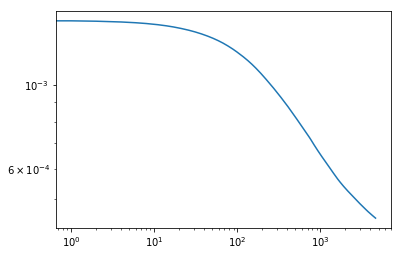

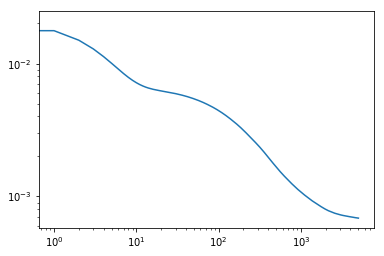

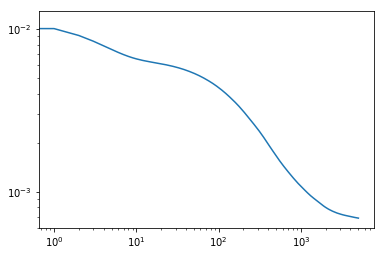

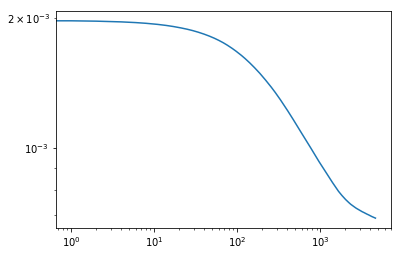

(8192,)
(8192, 1)


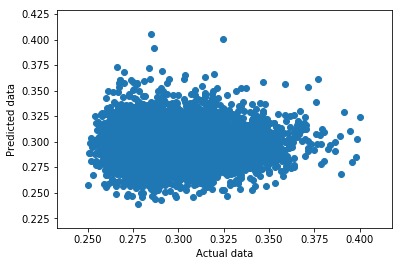

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                820       
_________________________________________________________________
activation_1 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 22)                462       
_________________________________________________________________
activation_2 (Activation)    (None, 22)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                460       
_________________________________________________________________
activation_3 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 22)                462       
__________

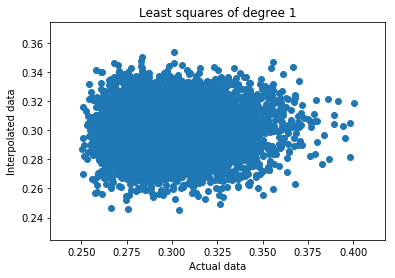

variance single level = 0.000485
variance diff ml = 0.000727 
speedup = 0.333333
(8192,)
variance_diff_interpolate = 0.000698
mean_qmc = 0.298482
mean_ml = 0.298947
mean_few_qmc = 19.843750
mean_lsq = 0.299919
(8192,)
mean_mlmlmc = 0.298892
var_qmc = 0.000485
var_ml = 0.000244
var_few_qmc = 14976.605225
(8192, 40)
var_lsq = 0.000229
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


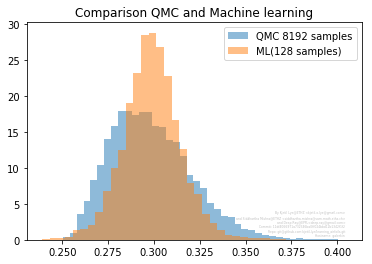

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


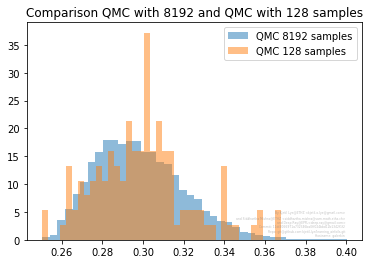

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


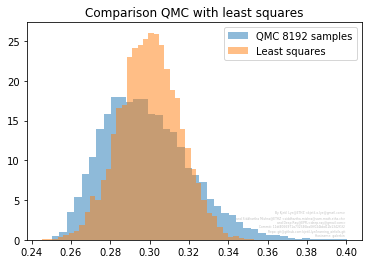

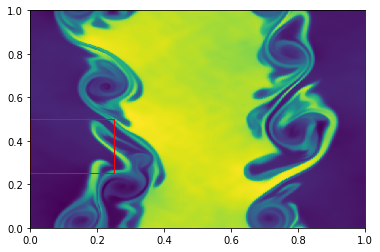

8191


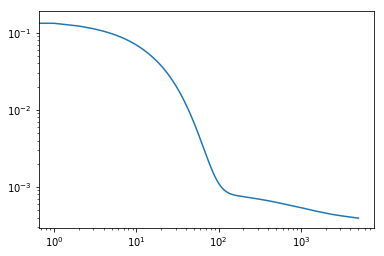

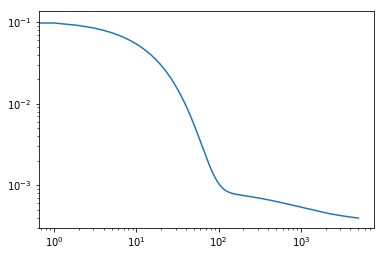

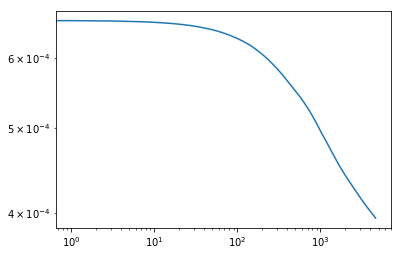

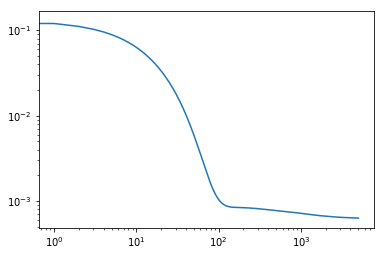

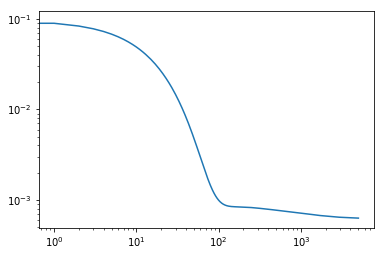

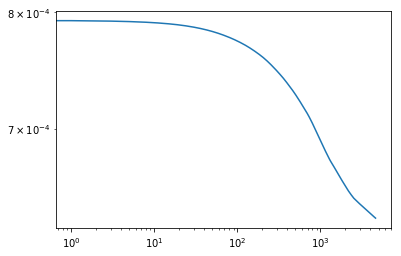

(8192,)
(8192, 1)


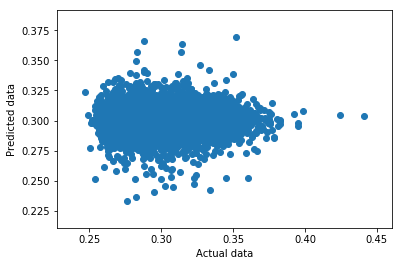

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 20)                820       
_________________________________________________________________
activation_7 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 22)                462       
_________________________________________________________________
activation_8 (Activation)    (None, 22)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 20)                460       
_________________________________________________________________
activation_9 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 22)                462       
__________

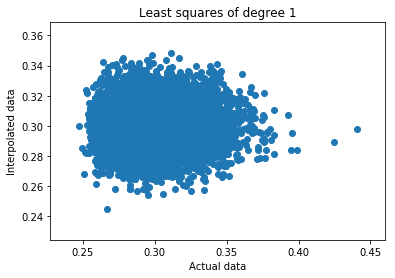

variance single level = 0.000491
variance diff ml = 0.000581 
speedup = 0.422119
(8192,)
variance_diff_interpolate = 0.000682
mean_qmc = 0.298271
mean_ml = 0.300609
mean_few_qmc = 19.843750
mean_lsq = 0.300698
(8192,)
mean_mlmlmc = 0.300575
var_qmc = 0.000491
var_ml = 0.000091
var_few_qmc = 14976.605225
(8192, 40)
var_lsq = 0.000192
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


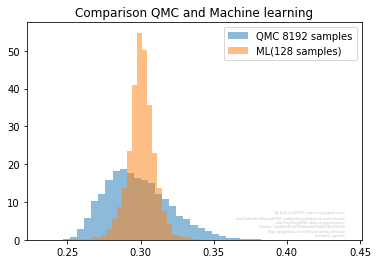

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


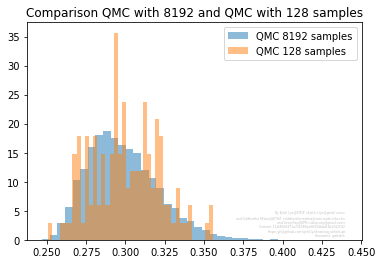

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


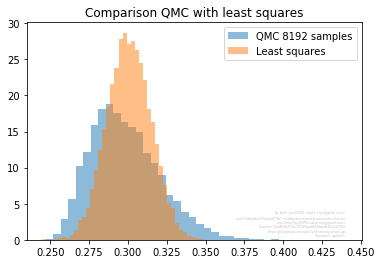

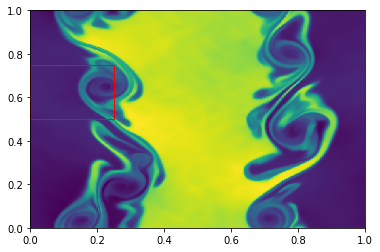

8191


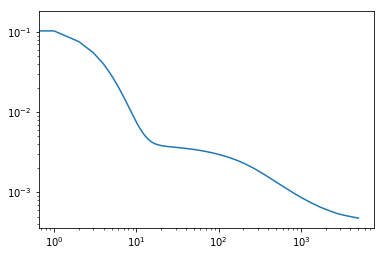

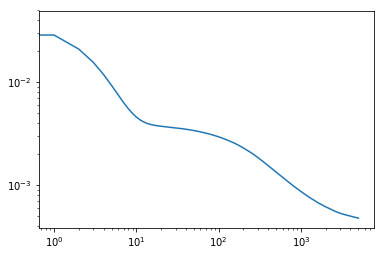

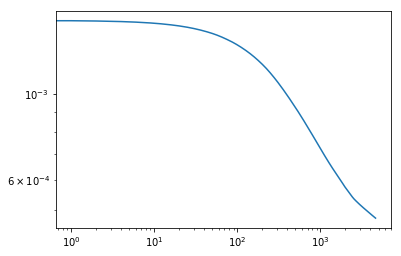

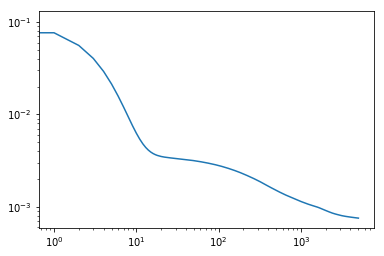

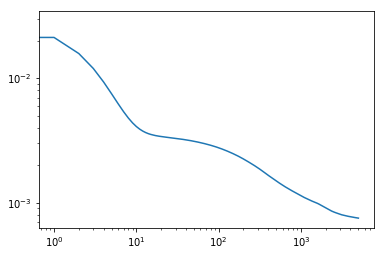

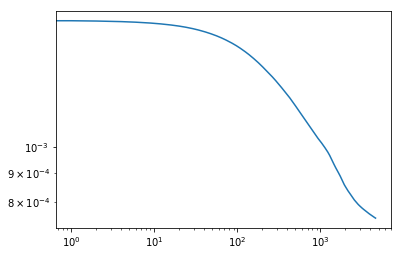

(8192,)
(8192, 1)


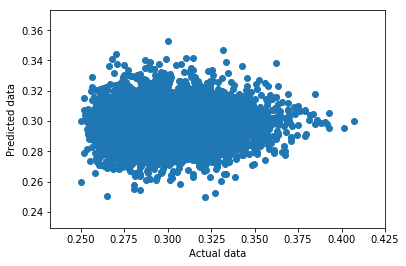

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 20)                820       
_________________________________________________________________
activation_13 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 22)                462       
_________________________________________________________________
activation_14 (Activation)   (None, 22)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 20)                460       
_________________________________________________________________
activation_15 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 22)                462       
__________

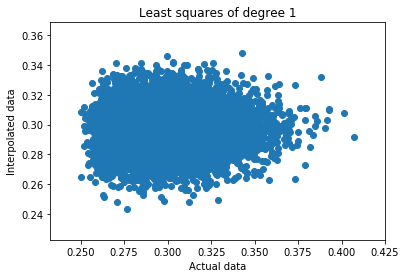

variance single level = 0.000492
variance diff ml = 0.000592 
speedup = 0.415835
(8192,)
variance_diff_interpolate = 0.000686
mean_qmc = 0.298235
mean_ml = 0.297690
mean_few_qmc = 19.843750
mean_lsq = 0.297093
(8192,)
mean_mlmlmc = 0.297672
var_qmc = 0.000492
var_ml = 0.000114
var_few_qmc = 14976.605225
(8192, 40)
var_lsq = 0.000207
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


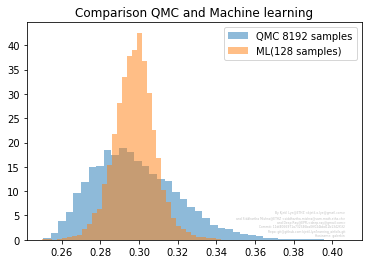

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


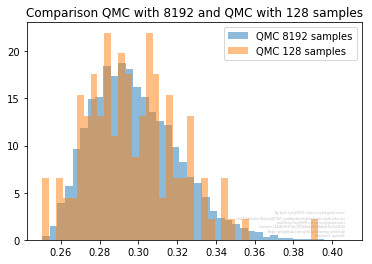

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


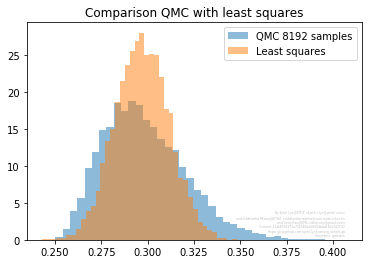

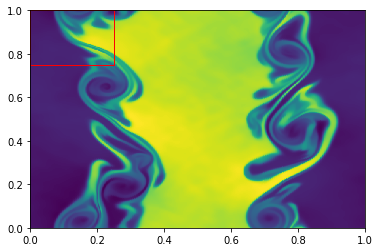

8191


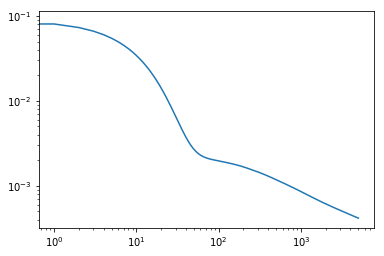

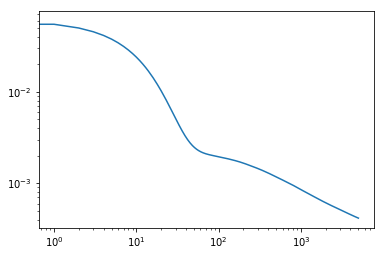

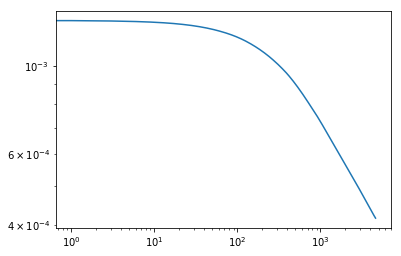

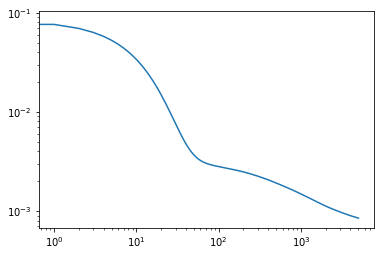

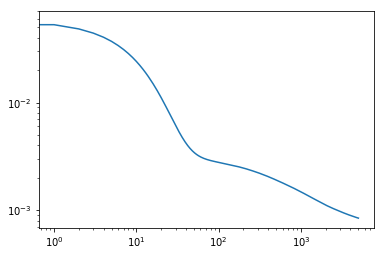

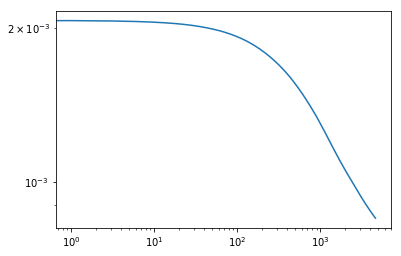

(8192,)
(8192, 1)


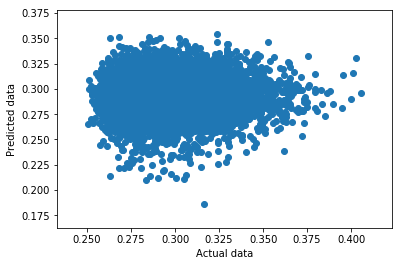

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 20)                820       
_________________________________________________________________
activation_19 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 22)                462       
_________________________________________________________________
activation_20 (Activation)   (None, 22)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 20)                460       
_________________________________________________________________
activation_21 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 22)                462       
__________

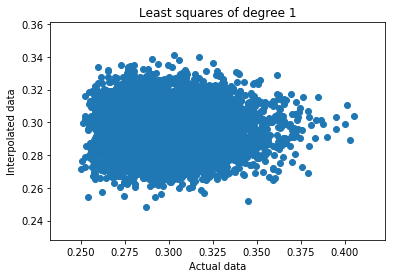

variance single level = 0.000490
variance diff ml = 0.000784 
speedup = 0.312706
(8192,)
variance_diff_interpolate = 0.000653
mean_qmc = 0.298132
mean_ml = 0.293063
mean_few_qmc = 19.843750
mean_lsq = 0.295984
(8192,)
mean_mlmlmc = 0.292917
var_qmc = 0.000490
var_ml = 0.000303
var_few_qmc = 14976.605225
(8192, 40)
var_lsq = 0.000163
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


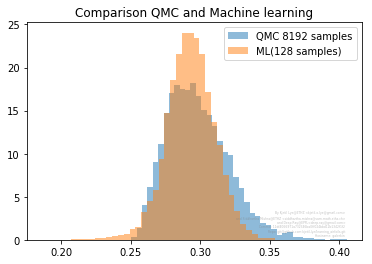

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


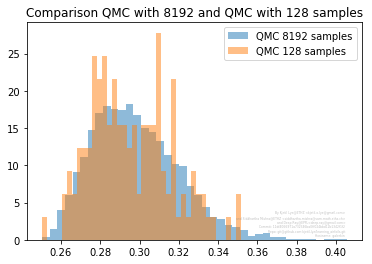

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


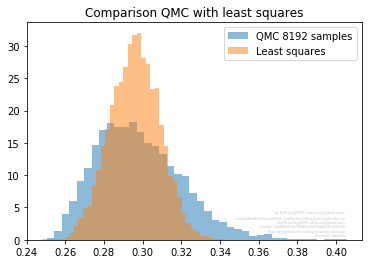

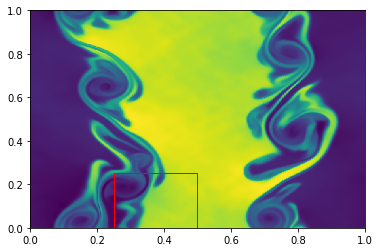

8191


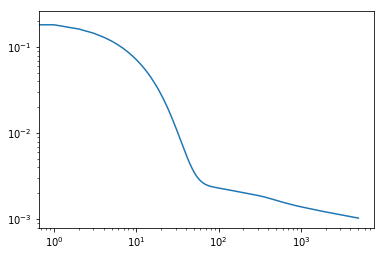

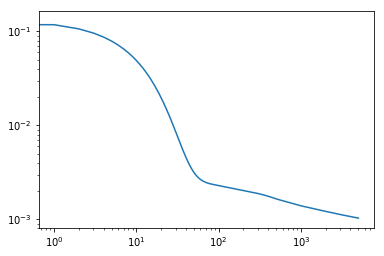

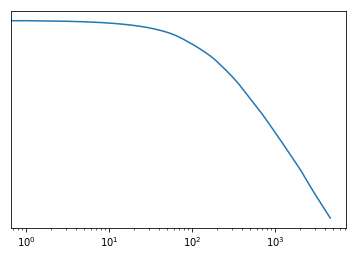

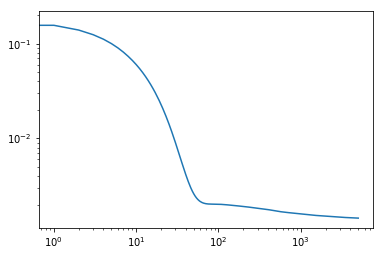

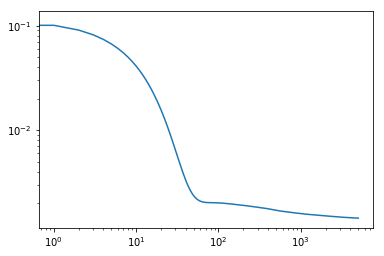

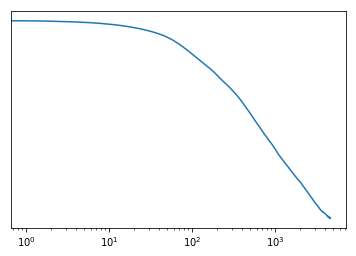

(8192,)
(8192, 1)


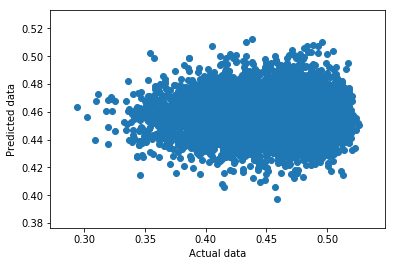

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 20)                820       
_________________________________________________________________
activation_25 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 22)                462       
_________________________________________________________________
activation_26 (Activation)   (None, 22)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 20)                460       
_________________________________________________________________
activation_27 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 22)                462       
__________

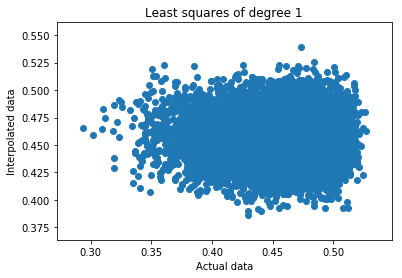

variance single level = 0.001308
variance diff ml = 0.001466 
speedup = 0.446181
(8192,)
variance_diff_interpolate = 0.001787
mean_qmc = 0.452236
mean_ml = 0.457764
mean_few_qmc = 19.843750
mean_lsq = 0.457189
(8192,)
mean_mlmlmc = 0.457633
var_qmc = 0.001308
var_ml = 0.000172
var_few_qmc = 14976.605225
(8192, 40)
var_lsq = 0.000458
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


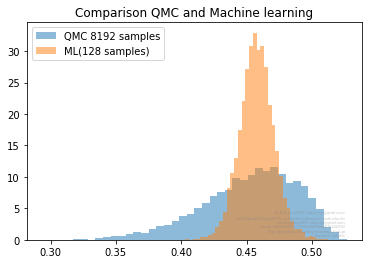

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


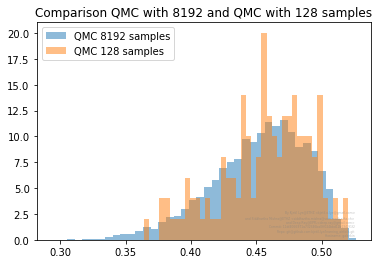

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


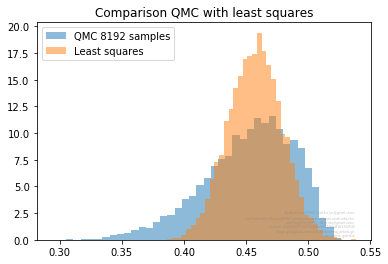

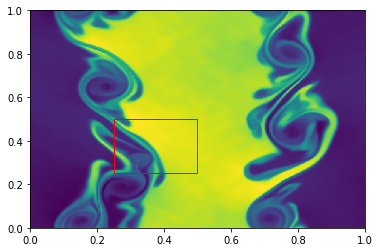

8191


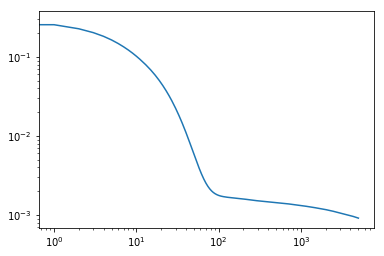

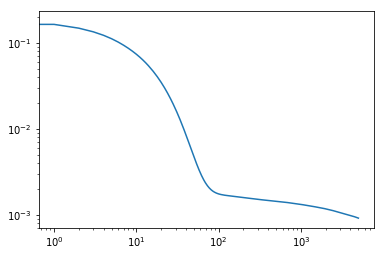

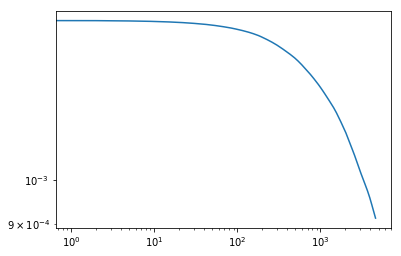

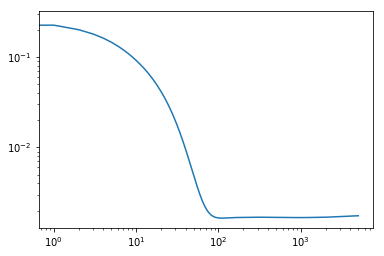

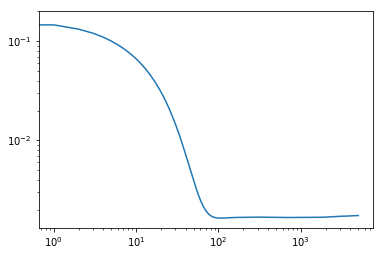

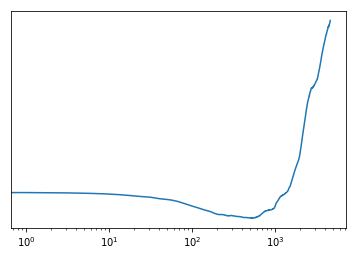

(8192,)
(8192, 1)


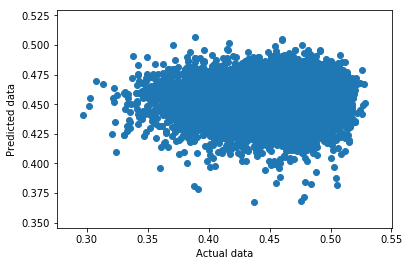

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 20)                820       
_________________________________________________________________
activation_31 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 22)                462       
_________________________________________________________________
activation_32 (Activation)   (None, 22)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 20)                460       
_________________________________________________________________
activation_33 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 22)                462       
__________

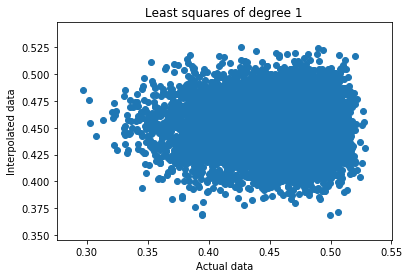

variance single level = 0.001317
variance diff ml = 0.001569 
speedup = 0.419494
(8192,)
variance_diff_interpolate = 0.001845
mean_qmc = 0.452045
mean_ml = 0.452117
mean_few_qmc = 19.843750
mean_lsq = 0.450814
(8192,)
mean_mlmlmc = 0.452113
var_qmc = 0.001317
var_ml = 0.000242
var_few_qmc = 14976.605225
(8192, 40)
var_lsq = 0.000536
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


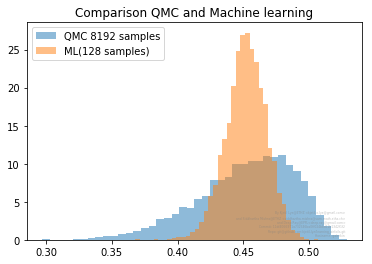

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


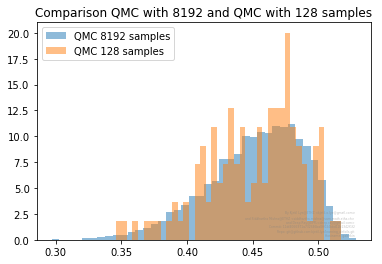

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


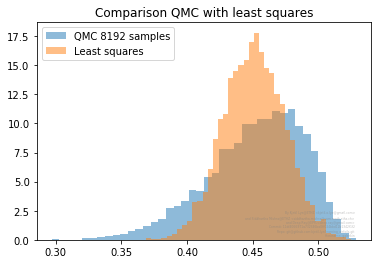

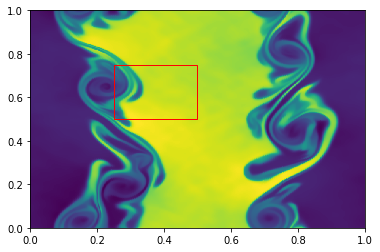

8191


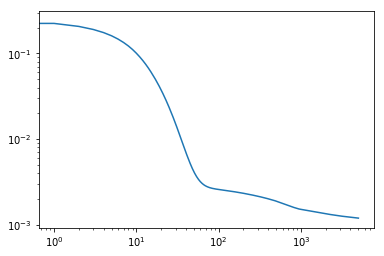

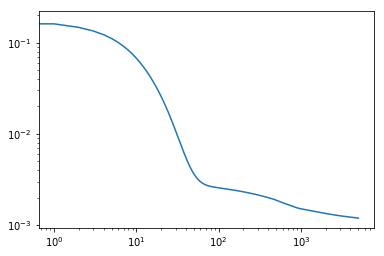

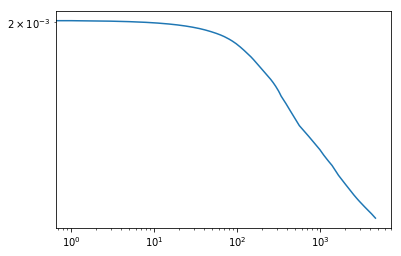

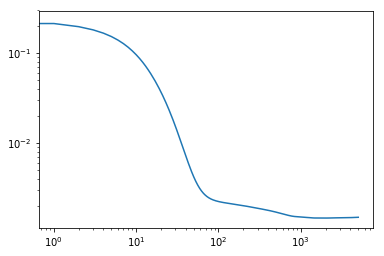

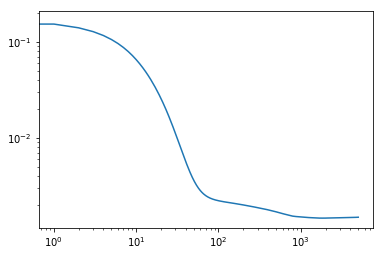

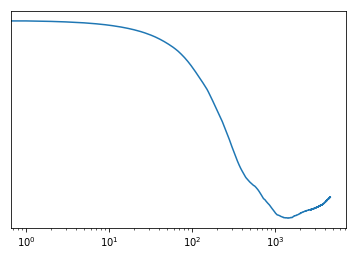

(8192,)
(8192, 1)


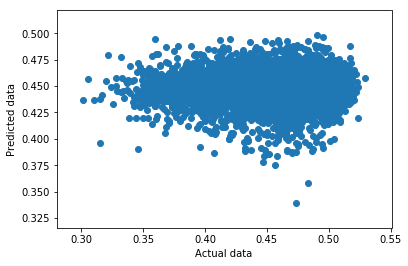

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 20)                820       
_________________________________________________________________
activation_37 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_44 (Dense)             (None, 22)                462       
_________________________________________________________________
activation_38 (Activation)   (None, 22)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 20)                460       
_________________________________________________________________
activation_39 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_46 (Dense)             (None, 22)                462       
__________

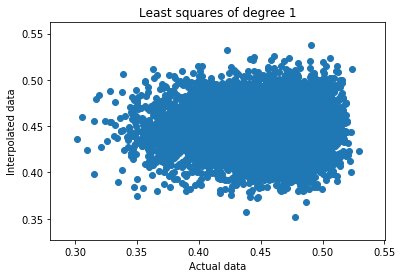

variance single level = 0.001299
variance diff ml = 0.001473 
speedup = 0.440897
(8192,)
variance_diff_interpolate = 0.001855
mean_qmc = 0.451353
mean_ml = 0.446484
mean_few_qmc = 19.843750
mean_lsq = 0.447798
(8192,)
mean_mlmlmc = 0.446381
var_qmc = 0.001299
var_ml = 0.000172
var_few_qmc = 14976.605225
(8192, 40)
var_lsq = 0.000571
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


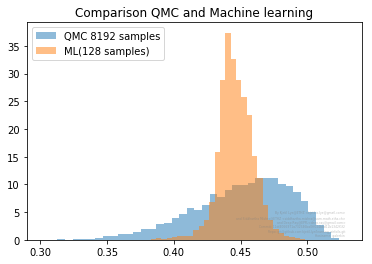

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


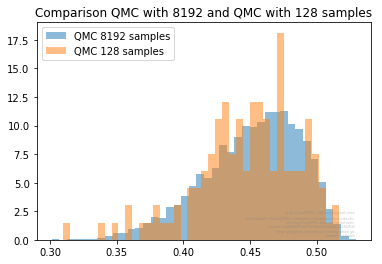

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


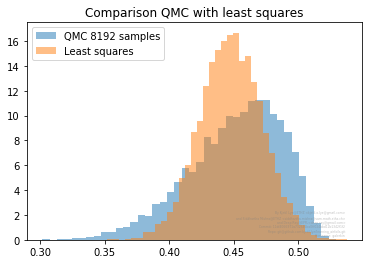

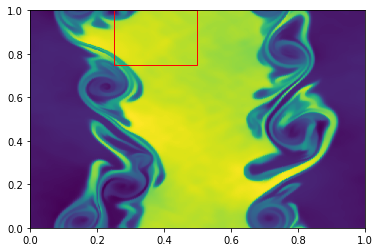

8191


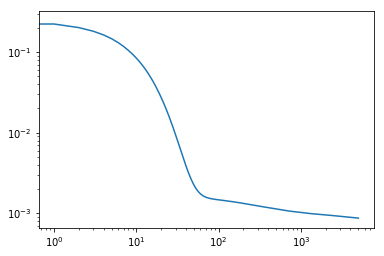

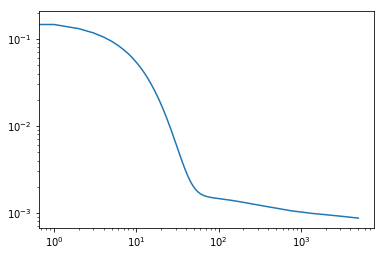

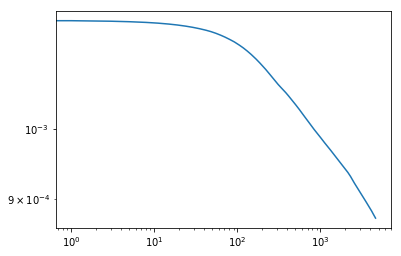

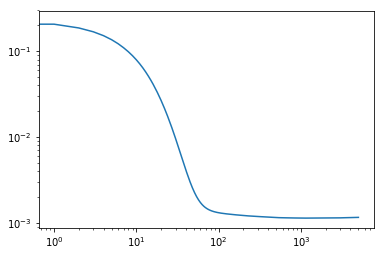

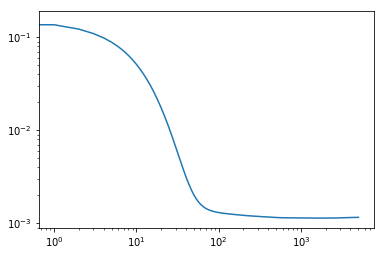

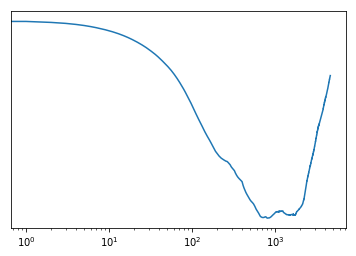

(8192,)
(8192, 1)


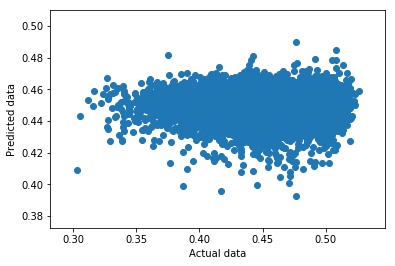

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 20)                820       
_________________________________________________________________
activation_43 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 22)                462       
_________________________________________________________________
activation_44 (Activation)   (None, 22)                0         
_________________________________________________________________
dense_52 (Dense)             (None, 20)                460       
_________________________________________________________________
activation_45 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_53 (Dense)             (None, 22)                462       
__________

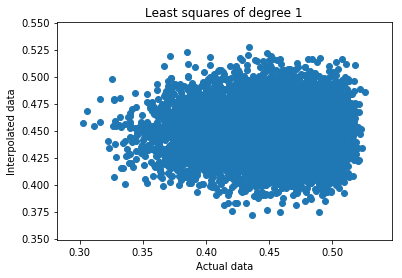

variance single level = 0.001352
variance diff ml = 0.001427 
speedup = 0.473526
(8192,)
variance_diff_interpolate = 0.001841
mean_qmc = 0.451176
mean_ml = 0.450060
mean_few_qmc = 19.843750
mean_lsq = 0.450144
(8192,)
mean_mlmlmc = 0.450041
var_qmc = 0.001352
var_ml = 0.000078
var_few_qmc = 14976.605225
(8192, 40)
var_lsq = 0.000498
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


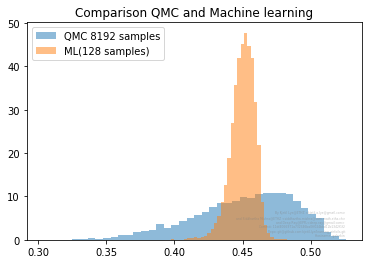

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


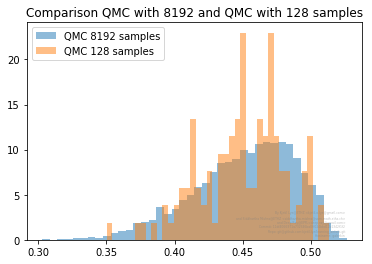

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


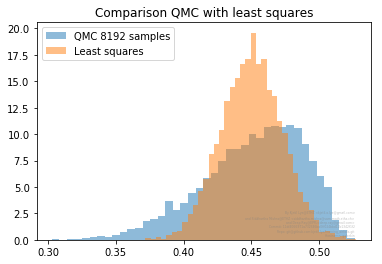

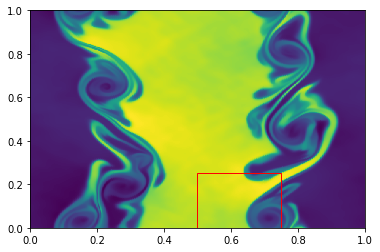

8191


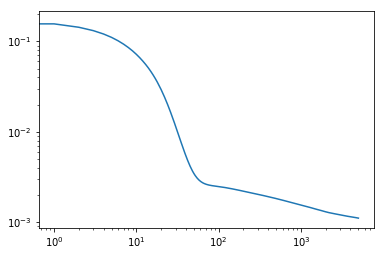

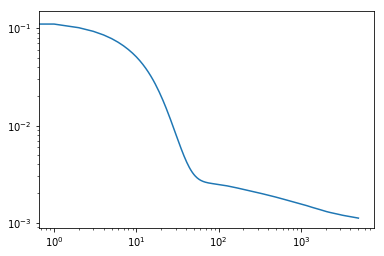

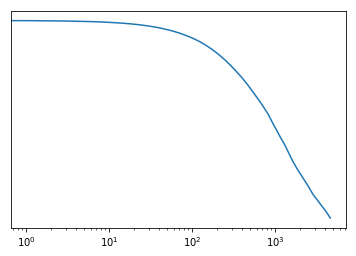

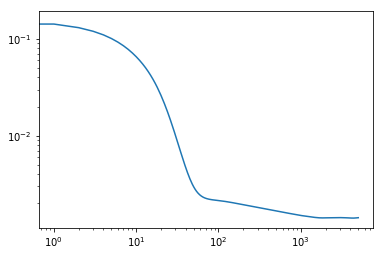

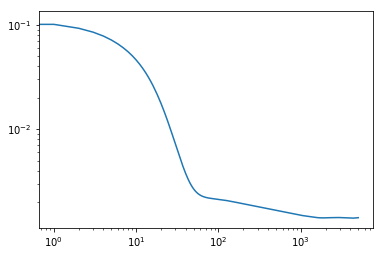

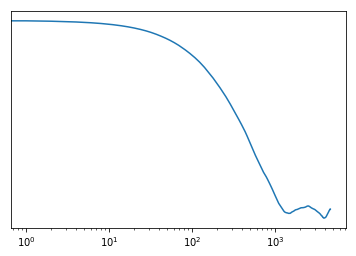

(8192,)
(8192, 1)


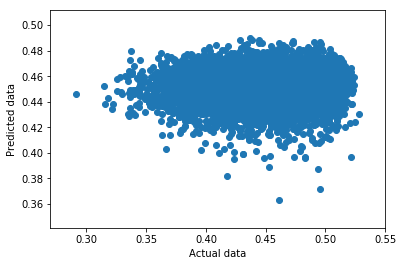

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             (None, 20)                820       
_________________________________________________________________
activation_49 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_58 (Dense)             (None, 22)                462       
_________________________________________________________________
activation_50 (Activation)   (None, 22)                0         
_________________________________________________________________
dense_59 (Dense)             (None, 20)                460       
_________________________________________________________________
activation_51 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_60 (Dense)             (None, 22)                462       
__________

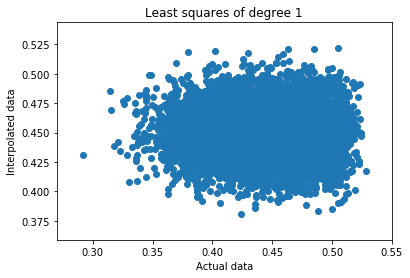

variance single level = 0.001343
variance diff ml = 0.001497 
speedup = 0.448858
(8192,)
variance_diff_interpolate = 0.001780
mean_qmc = 0.450964
mean_ml = 0.450218
mean_few_qmc = 19.843750
mean_lsq = 0.450719
(8192,)
mean_mlmlmc = 0.450145
var_qmc = 0.001343
var_ml = 0.000155
var_few_qmc = 14976.605225
(8192, 40)
var_lsq = 0.000416
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


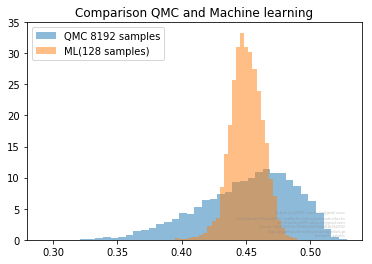

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


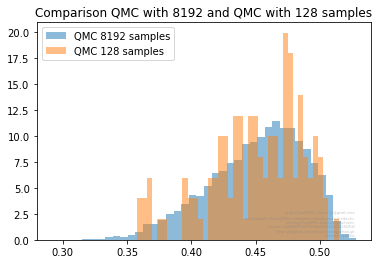

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


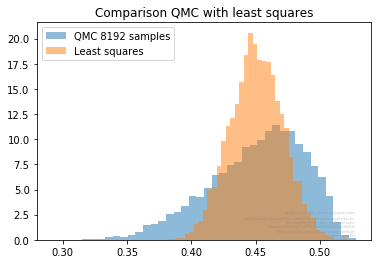

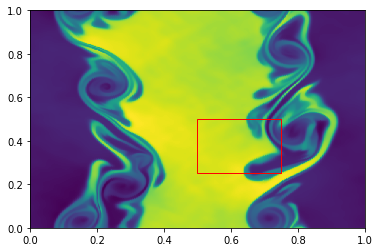

8191


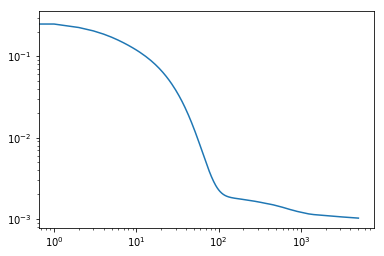

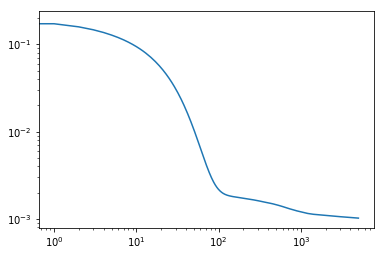

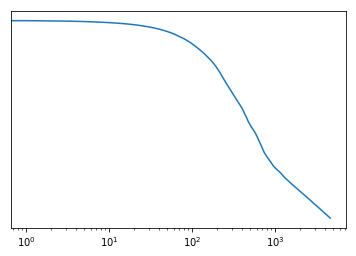

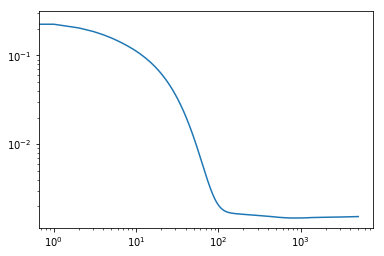

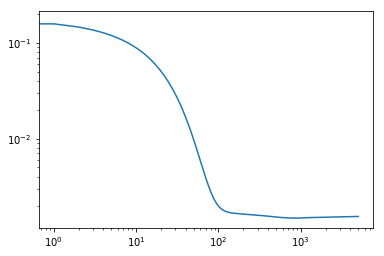

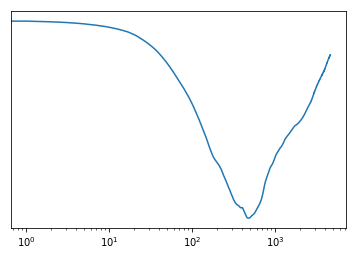

(8192,)
(8192, 1)


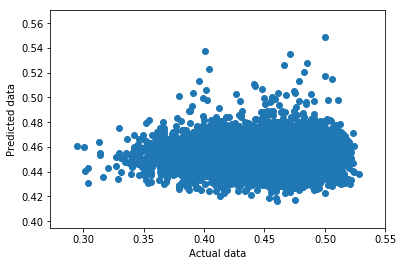

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 20)                820       
_________________________________________________________________
activation_55 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_65 (Dense)             (None, 22)                462       
_________________________________________________________________
activation_56 (Activation)   (None, 22)                0         
_________________________________________________________________
dense_66 (Dense)             (None, 20)                460       
_________________________________________________________________
activation_57 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_67 (Dense)             (None, 22)                462       
__________

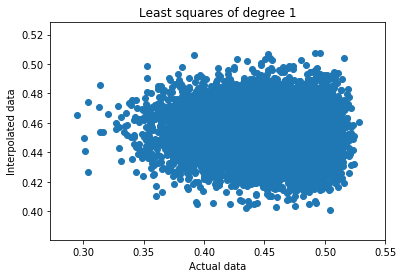

variance single level = 0.001291
variance diff ml = 0.001405 
speedup = 0.459548
(8192,)
variance_diff_interpolate = 0.001551
mean_qmc = 0.452078
mean_ml = 0.454291
mean_few_qmc = 19.843750
mean_lsq = 0.454147
(8192,)
mean_mlmlmc = 0.454195
var_qmc = 0.001291
var_ml = 0.000127
var_few_qmc = 14976.605225
(8192, 40)
var_lsq = 0.000252
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


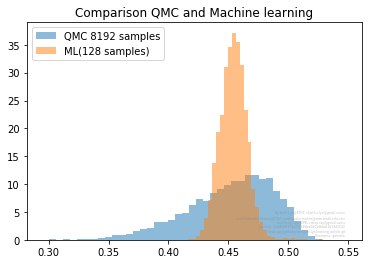

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


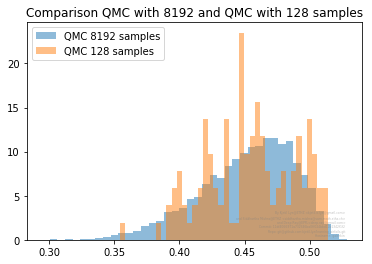

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


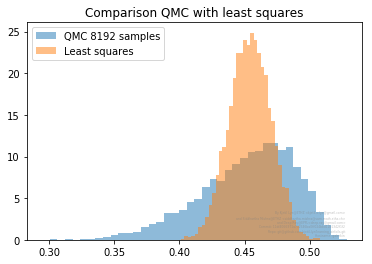

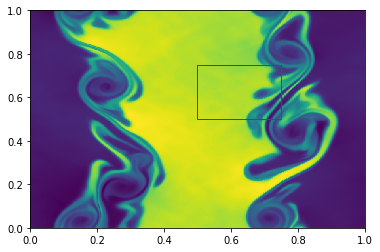

8191


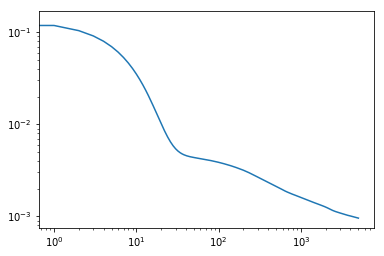

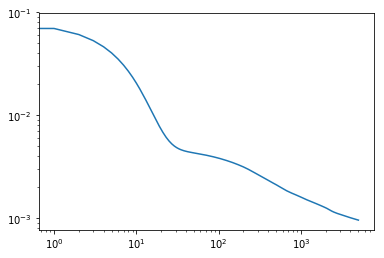

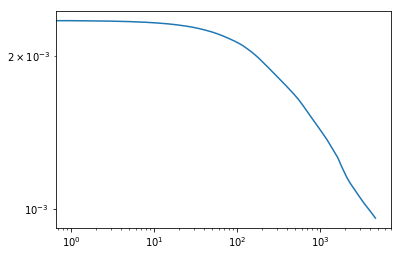

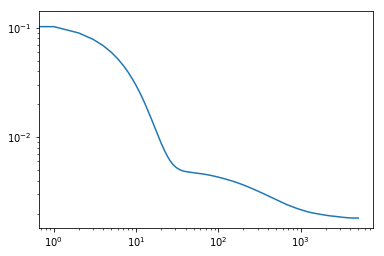

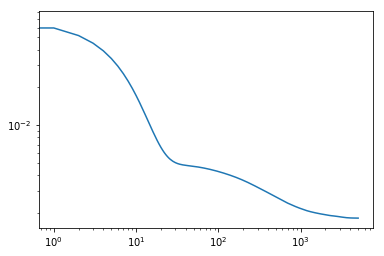

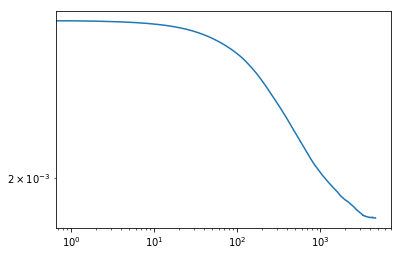

(8192,)
(8192, 1)


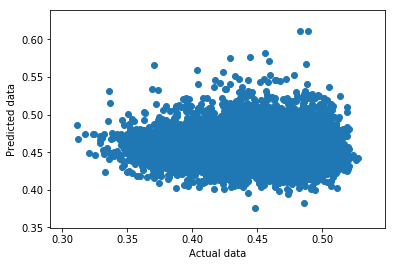

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_71 (Dense)             (None, 20)                820       
_________________________________________________________________
activation_61 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_72 (Dense)             (None, 22)                462       
_________________________________________________________________
activation_62 (Activation)   (None, 22)                0         
_________________________________________________________________
dense_73 (Dense)             (None, 20)                460       
_________________________________________________________________
activation_63 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_74 (Dense)             (None, 22)                462       
__________

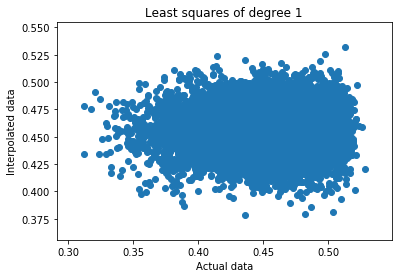

variance single level = 0.001326
variance diff ml = 0.001738 
speedup = 0.381524
(8192,)
variance_diff_interpolate = 0.001749
mean_qmc = 0.451570
mean_ml = 0.457418
mean_few_qmc = 19.843750
mean_lsq = 0.455151
(8192,)
mean_mlmlmc = 0.457376
var_qmc = 0.001326
var_ml = 0.000427
var_few_qmc = 14976.605225
(8192, 40)
var_lsq = 0.000427
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


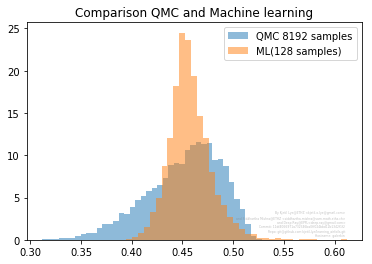

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


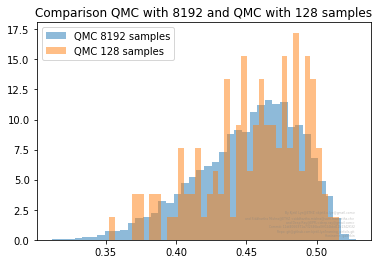

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


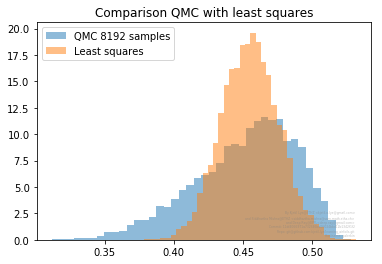

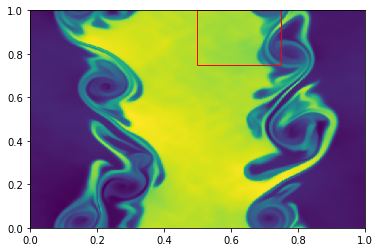

8191


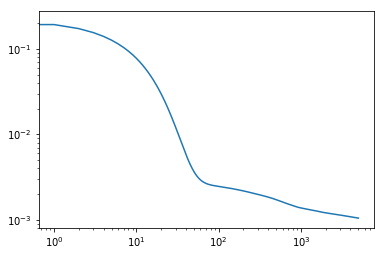

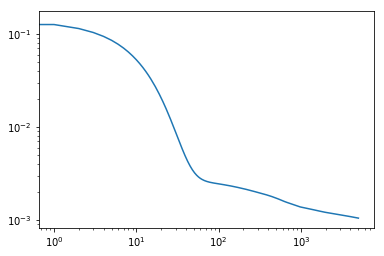

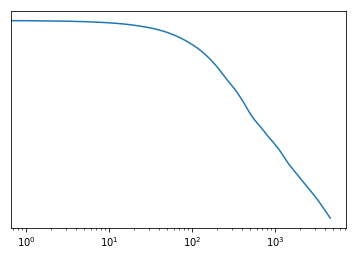

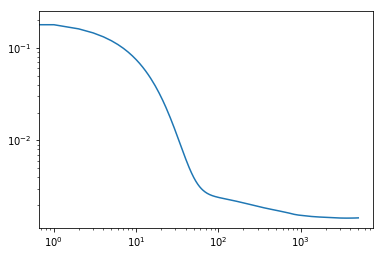

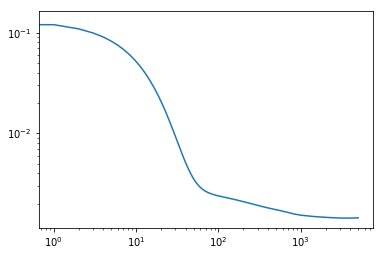

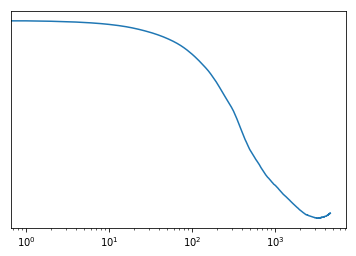

(8192,)
(8192, 1)


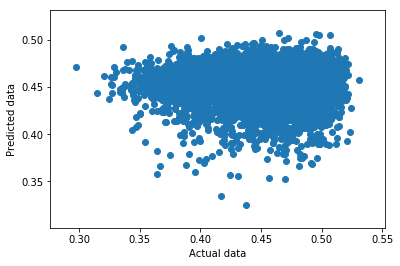

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_78 (Dense)             (None, 20)                820       
_________________________________________________________________
activation_67 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_79 (Dense)             (None, 22)                462       
_________________________________________________________________
activation_68 (Activation)   (None, 22)                0         
_________________________________________________________________
dense_80 (Dense)             (None, 20)                460       
_________________________________________________________________
activation_69 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_81 (Dense)             (None, 22)                462       
__________

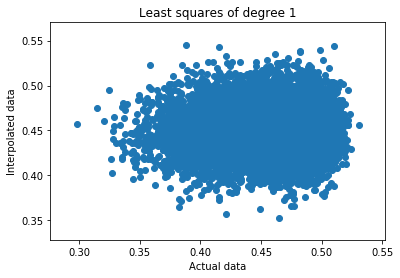

variance single level = 0.001278
variance diff ml = 0.001560 
speedup = 0.409786
(8192,)
variance_diff_interpolate = 0.001908
mean_qmc = 0.452396
mean_ml = 0.451378
mean_few_qmc = 19.843750
mean_lsq = 0.450941
(8192,)
mean_mlmlmc = 0.451379
var_qmc = 0.001278
var_ml = 0.000294
var_few_qmc = 14976.605225
(8192, 40)
var_lsq = 0.000665
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


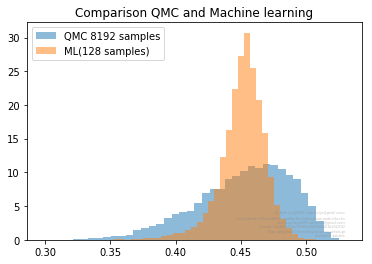

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


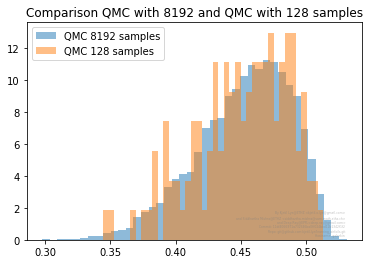

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


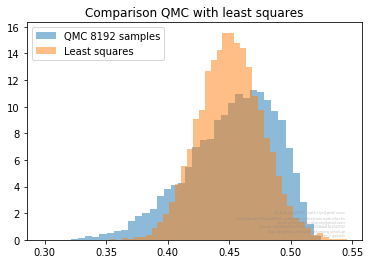

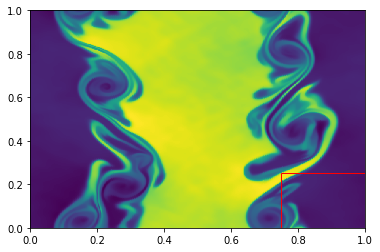

8191


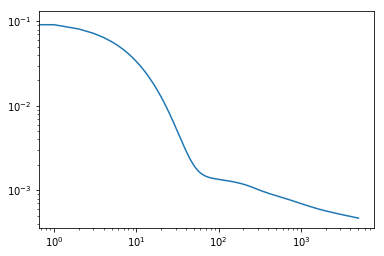

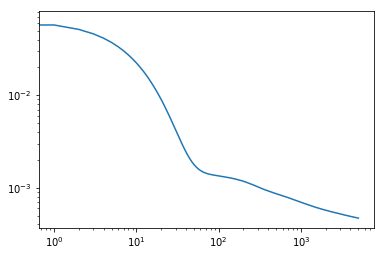

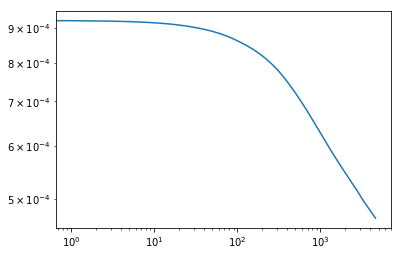

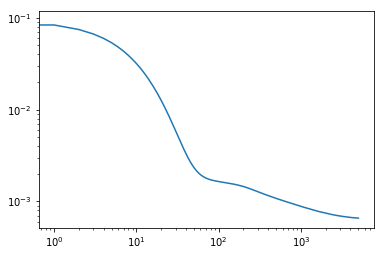

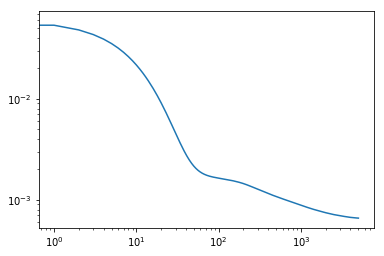

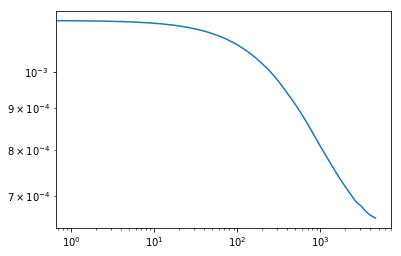

(8192,)
(8192, 1)


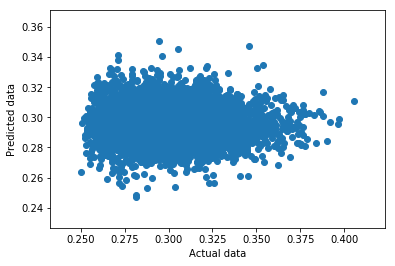

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_85 (Dense)             (None, 20)                820       
_________________________________________________________________
activation_73 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_86 (Dense)             (None, 22)                462       
_________________________________________________________________
activation_74 (Activation)   (None, 22)                0         
_________________________________________________________________
dense_87 (Dense)             (None, 20)                460       
_________________________________________________________________
activation_75 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_88 (Dense)             (None, 22)                462       
__________

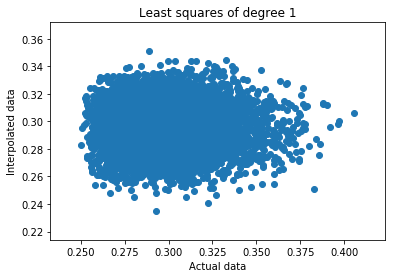

variance single level = 0.000493
variance diff ml = 0.000596 
speedup = 0.413273
(8192,)
variance_diff_interpolate = 0.000725
mean_qmc = 0.298064
mean_ml = 0.295356
mean_few_qmc = 19.843750
mean_lsq = 0.295375
(8192,)
mean_mlmlmc = 0.295294
var_qmc = 0.000493
var_ml = 0.000101
var_few_qmc = 14976.605225
(8192, 40)
var_lsq = 0.000239
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


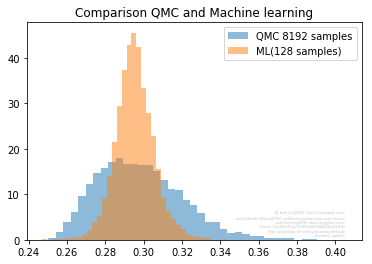

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


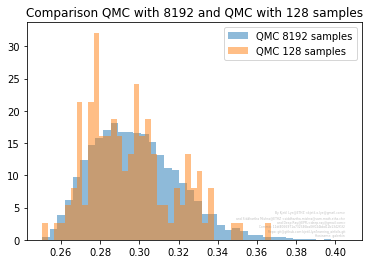

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


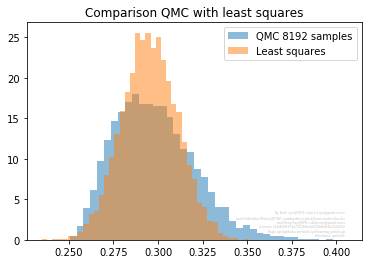

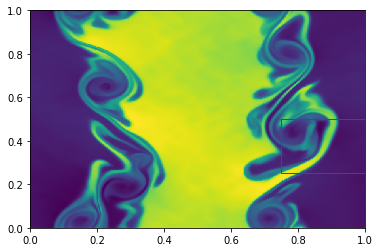

8191


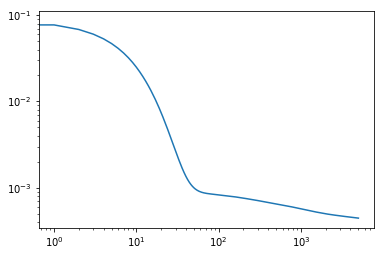

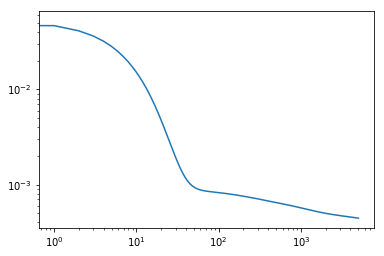

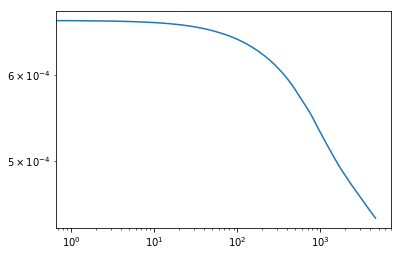

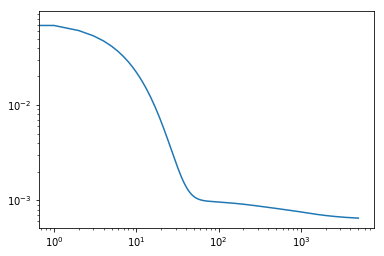

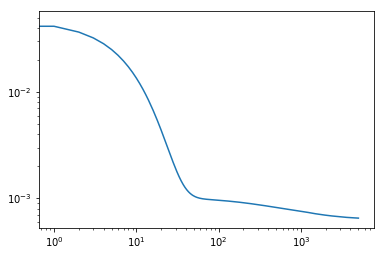

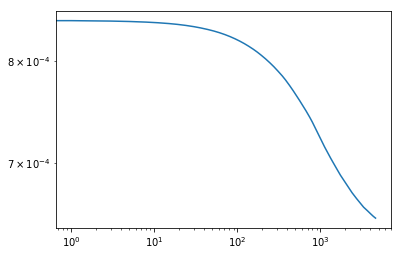

(8192,)
(8192, 1)


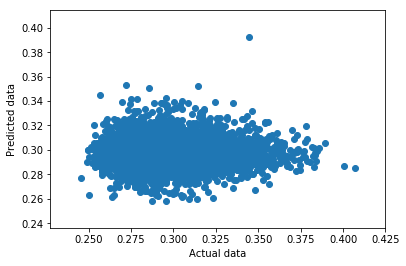

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_92 (Dense)             (None, 20)                820       
_________________________________________________________________
activation_79 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_93 (Dense)             (None, 22)                462       
_________________________________________________________________
activation_80 (Activation)   (None, 22)                0         
_________________________________________________________________
dense_94 (Dense)             (None, 20)                460       
_________________________________________________________________
activation_81 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_95 (Dense)             (None, 22)                462       
__________

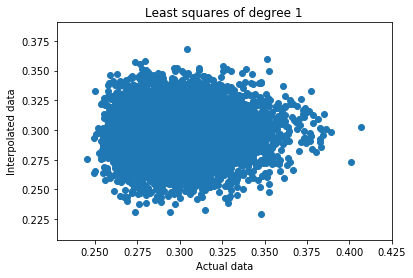

variance single level = 0.000484
variance diff ml = 0.000568 
speedup = 0.425475
(8192,)
variance_diff_interpolate = 0.000831
mean_qmc = 0.298174
mean_ml = 0.297393
mean_few_qmc = 19.843750
mean_lsq = 0.297460
(8192,)
mean_mlmlmc = 0.297372
var_qmc = 0.000484
var_ml = 0.000083
var_few_qmc = 14976.605225
(8192, 40)
var_lsq = 0.000354
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


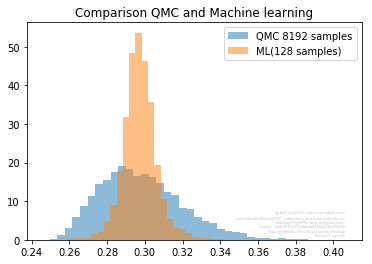

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


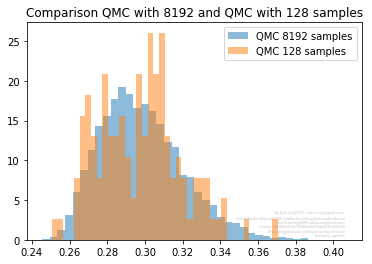

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


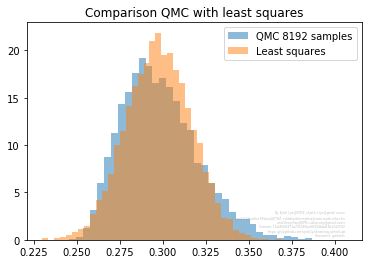

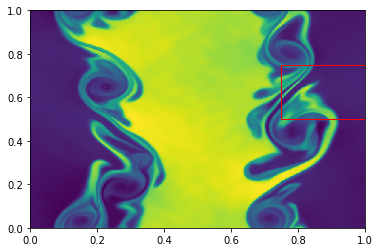

8191


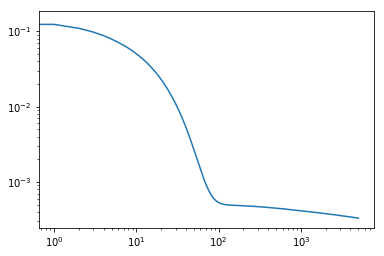

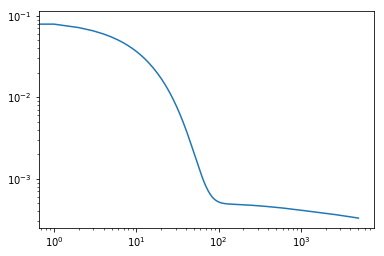

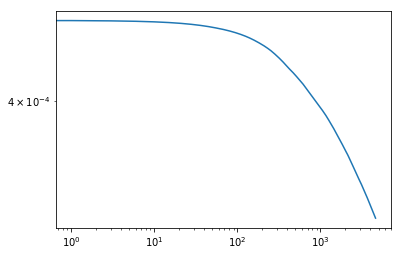

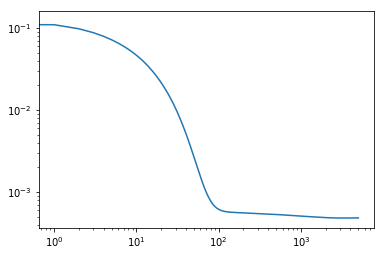

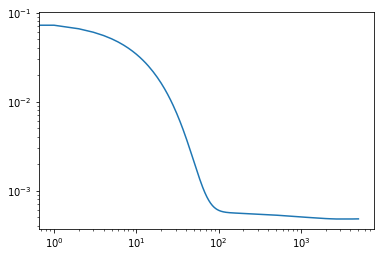

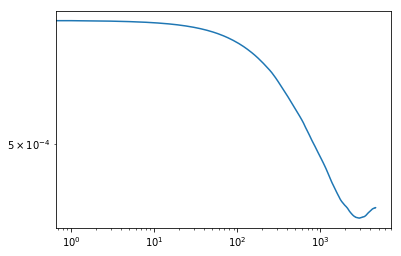

(8192,)
(8192, 1)


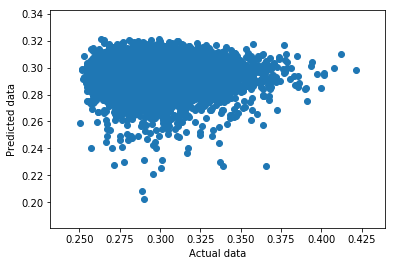

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_99 (Dense)             (None, 20)                820       
_________________________________________________________________
activation_85 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_100 (Dense)            (None, 22)                462       
_________________________________________________________________
activation_86 (Activation)   (None, 22)                0         
_________________________________________________________________
dense_101 (Dense)            (None, 20)                460       
_________________________________________________________________
activation_87 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_102 (Dense)            (None, 22)                462       
__________

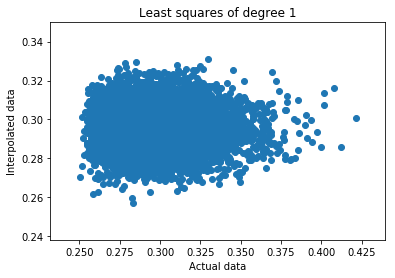

variance single level = 0.000500
variance diff ml = 0.000609 
speedup = 0.410724
(8192,)
variance_diff_interpolate = 0.000608
mean_qmc = 0.298460
mean_ml = 0.294872
mean_few_qmc = 19.843750
mean_lsq = 0.296034
(8192,)
mean_mlmlmc = 0.294869
var_qmc = 0.000500
var_ml = 0.000106
var_few_qmc = 14976.605225
(8192, 40)
var_lsq = 0.000103
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


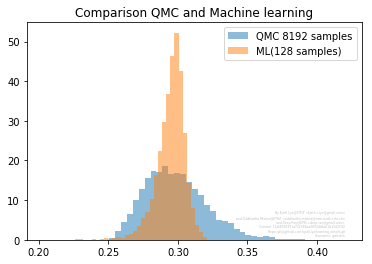

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


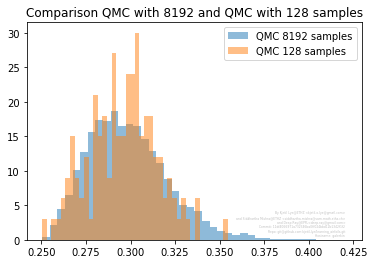

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


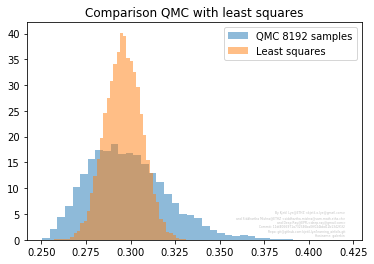

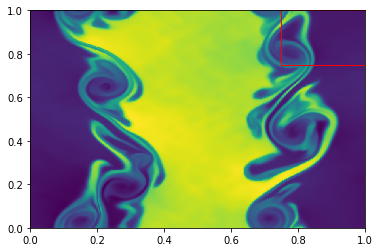

8191


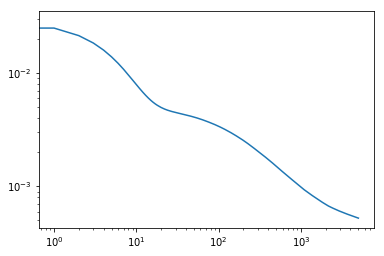

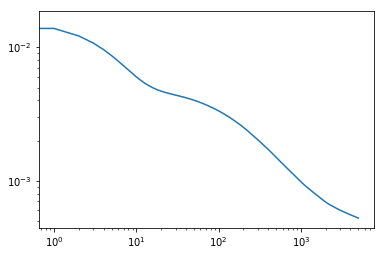

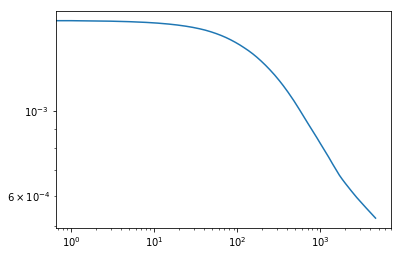

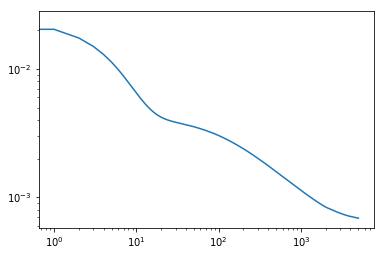

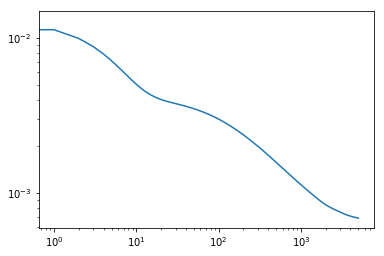

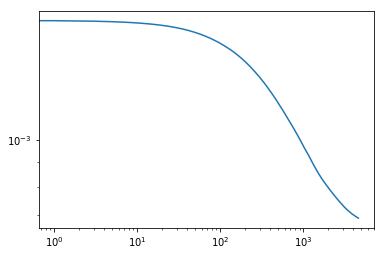

(8192,)
(8192, 1)


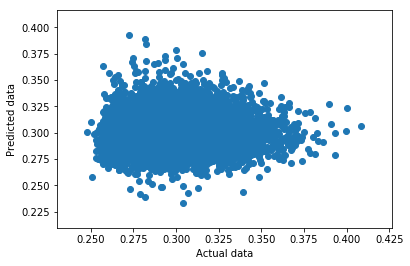

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_106 (Dense)            (None, 20)                820       
_________________________________________________________________
activation_91 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_107 (Dense)            (None, 22)                462       
_________________________________________________________________
activation_92 (Activation)   (None, 22)                0         
_________________________________________________________________
dense_108 (Dense)            (None, 20)                460       
_________________________________________________________________
activation_93 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_109 (Dense)            (None, 22)                462       
__________

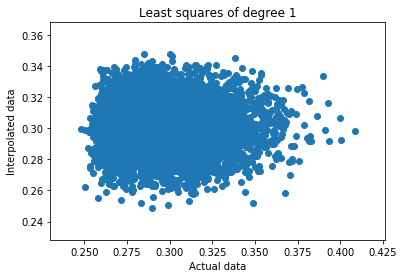

variance single level = 0.000493
variance diff ml = 0.000736 
speedup = 0.334918
(8192,)
variance_diff_interpolate = 0.000697
mean_qmc = 0.298366
mean_ml = 0.300133
mean_few_qmc = 19.843750
mean_lsq = 0.300524
(8192,)
mean_mlmlmc = 0.300077
var_qmc = 0.000493
var_ml = 0.000242
var_few_qmc = 14976.605225
(8192, 40)
var_lsq = 0.000212
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


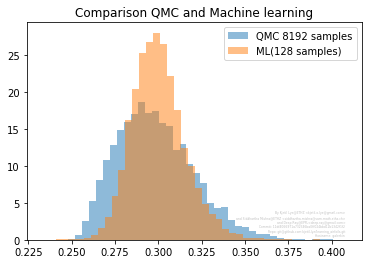

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


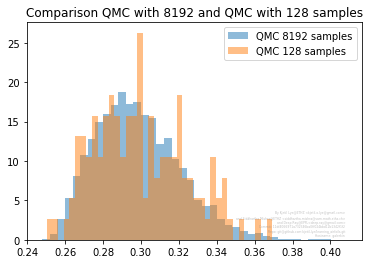

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


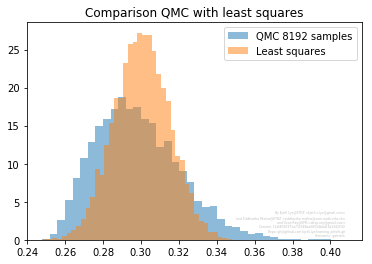

In [7]:
variables = ['rho']

points = []

for x in [0.0,0.25,0.5,0.75]:
    for y in [0.0,0.25,0.5,0.75]:
        points.append([x,y])

for v in variables:
    for p in points:
        
        try:
            prefix = '%s_%f_%f' % (v, p[0], p[1])
            prefix = prefix.replace('.','_')
            showAndSave.prefix = prefix
        
            network, data, parameters = get_network_interpolate_qmc(data_path, AreaFunctional(integrate_coordinate=p,variable=v))
        except Exception as e:
            print(e)
            pass


In [8]:
samples = get_samples(data_path, AreaFunctional())

8191


[0.45085875 0.39171593 0.46551893 ... 0.40834451 0.45144968 0.42880289]


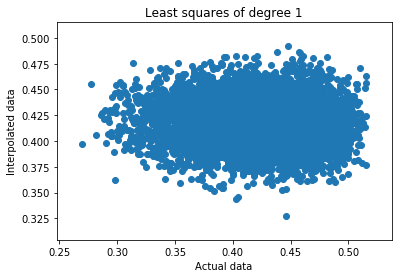

0.4196676291219611
0.4204606491342804
0.0016547239945216671
0.0004224001428405972


In [9]:
parameter_path = os.path.join(os.path.dirname(data_path), 'qmc_points.txt')
parameters = loadtxt(parameter_path)
from sklearn import linear_model
data = samples

print(data)
reg_size = 128
reg = linear_model.LinearRegression()
y_train = data[:reg_size]
coeffs = reg.fit(parameters[:reg_size,:], y_train)

evaluated_lsq = coeffs.predict(parameters)
plt.scatter(data, evaluated_lsq)
plt.title('Least squares of degree 1')
plt.xlabel("Actual data")
plt.ylabel("Interpolated data")
plt.show()
print(sum(evaluated_lsq)/len(evaluated_lsq))
print(sum(data)/len(data))
print(var(data))
print(var(evaluated_lsq))

In [10]:
func=AreaFunctional()
with netCDF4.Dataset(data_path) as f:
    d = f.variables['sample_10_rho'][:,:,0]
    r = func(d)
    print(r)

0.4237384807612413


In [11]:

a=linspace(0,10)
print(isnan(a))
print(type(samples))
print(type(a))
print(samples.shape)
print(a.shape)
print(a.dtype)
print(samples.dtype)
samples2 = samples.astype(float64)
print(samples[0])
print(isnan(samples2))


[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(8192,)
(50,)
float64
float64
0.4508587522090691
[False False False ... False False False]
